In [1]:
import numpy as np
import pickle
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/home/luqman/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation

In [6]:
train_annotation_path = '/nas/database/Big5/gt/annotation_training.pkl'
val_annotation_path = '/nas/database/Big5/gt/annotation_validation.pkl'
test_annotation_path = '/nas/database/Big5/gt/annotation_test.pkl'

with open(train_annotation_path, 'rb') as f:
    train_annotation = pickle.load(f, encoding='latin1')
train_videos = list(train_annotation['extraversion'].keys())

with open(val_annotation_path, 'rb') as f:
    val_annotation = pickle.load(f, encoding='latin1')
val_videos = list(val_annotation['extraversion'].keys())

with open(test_annotation_path, 'rb') as f:
    test_annotation = pickle.load(f, encoding='latin1')
test_videos = list(test_annotation['extraversion'].keys())

with open('/home/luqman/FI_AU/mean_std.npy', 'rb') as f:
    mean_std_au = np.load(f)

In [7]:
train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []
train_data_path = '/home/luqman/FI_AU/train_npy'
val_data_path = '/home/luqman/FI_AU/valid_npy'
test_data_path = '/home/luqman/FI_AU/test_npy'

In [8]:
for i, video in enumerate(train_videos):
    video_name = video.rsplit(".")[0] + '.' + video.rsplit(".")[1]
    input_name = video_name + '.npy'
    input_path = os.path.join(train_data_path, input_name)
    with open(input_path, 'rb') as f:
        au = np.load(f)
        au = (au - mean_std_au[:,0]) / mean_std_au[:,1]
        if au.shape[0] < 450:
            au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)

    # Include only 11 AU
    au = au[:,:11]
    train_features.append(au)
    
    label = np.array([train_annotation['extraversion'][video],
                     train_annotation['neuroticism'][video],
                     train_annotation['agreeableness'][video],
                     train_annotation['conscientiousness'][video],
                     train_annotation['openness'][video]])
    train_labels.append(label)
    
for i, video in enumerate(val_videos):
    video_name = video.rsplit(".")[0] + '.' + video.rsplit(".")[1]
    input_name = video_name + '.npy'
    input_path = os.path.join(val_data_path, input_name)
    with open(input_path, 'rb') as f:
        au = np.load(f)
        au = (au - mean_std_au[:,0]) / mean_std_au[:,1]
        if au.shape[0] < 450:
            au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    
    # Include only 11 AU
    au = au[:,:11]
    val_features.append(au)
    
    label = np.array([val_annotation['extraversion'][video],
                     val_annotation['neuroticism'][video],
                     val_annotation['agreeableness'][video],
                     val_annotation['conscientiousness'][video],
                     val_annotation['openness'][video]])
    val_labels.append(label)
    
for i, video in enumerate(test_videos):
    video_name = video.rsplit(".")[0] + '.' + video.rsplit(".")[1]
    input_name = video_name + '.npy'
    input_path = os.path.join(test_data_path, input_name)
    with open(input_path, 'rb') as f:
        au = np.load(f)
        au = (au - mean_std_au[:,0]) / mean_std_au[:,1]
        if au.shape[0] < 450:
            au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    # Include only 11 AU
    au = au[:,:11]
    test_features.append(au)
    
    label = np.array([test_annotation['extraversion'][video],
                     test_annotation['neuroticism'][video],
                     test_annotation['agreeableness'][video],
                     test_annotation['conscientiousness'][video],
                     test_annotation['openness'][video]])
    test_labels.append(label)

In [9]:
train_features = torch.Tensor(np.array(train_features))
train_labels = torch.Tensor(np.array(train_labels))
val_features = torch.Tensor(np.array(val_features))
val_labels = torch.Tensor(np.array(val_labels))
test_features = torch.Tensor(np.array(test_features))
test_labels = torch.Tensor(np.array(test_labels))

BATCH_SIZE = 256
train = TensorDataset(train_features, train_labels)
val = TensorDataset(val_features, val_labels)
test = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Model

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# GRU

In [39]:
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional, output_dim, dropout, num_layers, batch_size):
        super(GRU_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = dropout
        self.gru = torch.nn.GRU(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                dropout=self.dropout,
                                bidirectional=bidirectional,
                                batch_first=True)
        self.fc = torch.nn.Linear(hidden_size if not bidirectional else hidden_size * 2, output_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out, h = self.gru(x)
        out = self.relu(out[:,-1,:])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

In [57]:
LR = 0.0001
CHECKPOINT_PATH = "/home/luqman/model/checkpoint_gru_new_au.ckpt"

In [55]:
model = GRU_model(input_size=11, 
                  hidden_size=256, 
                  bidirectional=True, 
                  output_dim=5, 
                  dropout=0.2, 
                  num_layers=2, 
                  batch_size=BATCH_SIZE)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

In [56]:
# checkpoint = torch.load(CHECKPOINT_PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# LSTM

In [24]:
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_dim, dropout, num_layers, bidirectional, batch_size):
        super(LSTM_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = dropout
        self.lstm = torch.nn.LSTM(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                dropout=self.dropout,
                                bidirectional=False,
                                batch_first=True)
        self.fc = torch.nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.relu(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

In [25]:
LR = 0.001
CHECKPOINT_PATH = "/home/luqman/model/checkpoint_lstm_new_au.ckpt"

In [26]:
model = LSTM_model(input_size=11, 
                   hidden_size=256, 
                   output_dim=5, 
                   dropout=0.1, 
                   num_layers=2,
                   bidirectional=False,
                   batch_size=BATCH_SIZE)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

# Training

In [58]:
def train(model, train_loader, val_loader, epochs, patience=5):
    train_losses = []
    val_losses = []
    val_maes = []

    the_last_loss = 1e6
    trigger_times = 0

    for epoch in range(0, epochs):
        model.train()
        batch_losses = []

        for inputs, targets in train_loader:
            preds = model(inputs.to(device))
            loss = loss_fn(preds, targets.to(device))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            batch_val_losses = []
            batch_val_mae = []

            for inputs, targets in val_loader:
                model.eval()
                preds = model(inputs.to(device))
                loss = loss_fn(preds, targets.to(device))
                batch_val_losses.append(loss.item())
                val_mae = mae(preds, targets.to(device))
                batch_val_mae.append(val_mae.item())
            val_loss = np.mean(batch_val_losses)
            val_mae = np.mean(batch_val_mae)
            scheduler.step(val_loss)
            val_losses.append(val_loss)
            val_maes.append(val_mae)

        if epoch % 5 == 0:    
            print(f'Epoch {epoch} - train loss: {train_loss} - val loss: {val_loss} - val 1-mae: {1-val_mae}')
        
        # early stopping
        if val_loss > the_last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early Stopping!')
                break
        else:
            print('Trigger Times: 0')
            trigger_times = 0
        the_last_loss = val_loss
            
    return train_losses, val_losses, val_maes

In [59]:
train_losses, val_losses, val_maes = train(model, train_loader, val_loader, epochs=50, patience=4)

Epoch 0 - train loss: 0.023192766243996826 - val loss: 0.021208911069801877 - val 1-mae: 0.8827184683510235
Trigger Times: 0
Trigger Times: 0
Trigger Times: 0
Trigger Times: 1
Trigger Times: 2
Epoch 5 - train loss: 0.02204282306458639 - val loss: 0.020647880754300525 - val 1-mae: 0.8844441452196666
Trigger Times: 0
Trigger Times: 1
Trigger Times: 2
Trigger Times: 0
Trigger Times: 0
Epoch 10 - train loss: 0.02174324064475039 - val loss: 0.020834109878965786 - val 1-mae: 0.8840790699635234
Trigger Times: 1
Trigger Times: 2
Trigger Times: 0
Trigger Times: 1
Trigger Times: 0
Epoch 15 - train loss: 0.021423063362422196 - val loss: 0.020278123606528555 - val 1-mae: 0.8857554420828819
Trigger Times: 0
Trigger Times: 0
Trigger Times: 1
Trigger Times: 0
Trigger Times: 1
Epoch 20 - train loss: 0.020945471104072487 - val loss: 0.01971327220754964 - val 1-mae: 0.887212298810482
Trigger Times: 0
Trigger Times: 1
Trigger Times: 2
Trigger Times: 0
Trigger Times: 1
Epoch 25 - train loss: 0.02030462642

# Plot

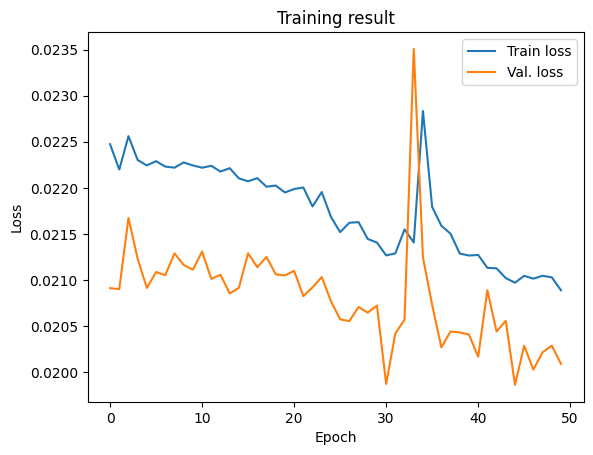

In [29]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Val. loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title("Training result")
plt.legend()

# Save model

In [61]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, CHECKPOINT_PATH)

In [62]:
model

GRU_model(
  (gru): GRU(11, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

# Testing

In [60]:
mae = torch.nn.L1Loss()
model.eval()
with torch.no_grad():
    batch_loss_ext = []
    batch_loss_neu = []
    batch_loss_agr = []
    batch_loss_con = []
    batch_loss_ope = []

    batch_r2_ext = []
    batch_r2_neu = []
    batch_r2_agr = []
    batch_r2_con = []
    batch_r2_ope = []

    for inputs, targets in test_loader:
        model.eval()
        preds = model(inputs.to(device))
        
        loss_ext = mae(preds[:,0], targets[:,0].to(device))
        loss_neu = mae(preds[:,1], targets[:,1].to(device))
        loss_agr = mae(preds[:,2], targets[:,2].to(device))
        loss_con = mae(preds[:,3], targets[:,3].to(device))
        loss_ope = mae(preds[:,4], targets[:,4].to(device))
        batch_loss_ext.append(loss_ext.item())
        batch_loss_neu.append(loss_neu.item())
        batch_loss_agr.append(loss_agr.item())
        batch_loss_con.append(loss_con.item())
        batch_loss_ope.append(loss_ope.item())
        
        r2_ext = r2_score(preds.cpu()[:,0], targets[:,0])
        r2_neu = r2_score(preds.cpu()[:,1], targets[:,1])
        r2_agr = r2_score(preds.cpu()[:,2], targets[:,2])
        r2_con = r2_score(preds.cpu()[:,3], targets[:,3])
        r2_ope = r2_score(preds.cpu()[:,4], targets[:,4])
        batch_r2_ext.append(r2_ext)
        batch_r2_neu.append(r2_neu)
        batch_r2_agr.append(r2_agr)
        batch_r2_con.append(r2_con)
        batch_r2_ope.append(r2_ope)
        
    loss_ext = 1 - np.mean(batch_loss_ext)
    loss_neu = 1 - np.mean(batch_loss_neu)
    loss_agr = 1 - np.mean(batch_loss_agr)
    loss_con = 1 - np.mean(batch_loss_con)
    loss_ope = 1 - np.mean(batch_loss_ope)
    loss = (loss_ext + loss_neu + loss_agr + loss_con + loss_ope) / 5
    
    r2_ext = np.array(batch_r2_ext).mean()
    r2_neu = np.array(batch_r2_neu).mean()
    r2_agr = np.array(batch_r2_agr).mean()
    r2_con = np.array(batch_r2_con).mean()
    r2_ope = np.array(batch_r2_ope).mean()
    r2 = (r2_ext + r2_neu + r2_agr + r2_con + r2_ope) / 5
    
    print(f'1-MAE: {loss}')
    print(f'1-MAE Extraversion: {loss_ext}')
    print(f'1-MAE Neuroticism: {loss_neu}')
    print(f'1-MAE Agreeableness: {loss_agr}')
    print(f'1-MAE Conscientiousness: {loss_con}')
    print(f'1-MAE Openness: {loss_ope}')
    print(f'r2_extraversion: {r2_ext}')
    print(f'r2_neuroticism: {r2_neu}')
    print(f'r2_agreeableness: {r2_agr}')
    print(f'r2_conscientiousness: {r2_con}')
    print(f'r2_openness: {r2_ope}')
    print(f'r2: {r2}')

1-MAE: 0.8878489085606166
1-MAE Extraversion: 0.8875636862857001
1-MAE Neuroticism: 0.8835576740758759
1-MAE Agreeableness: 0.8952643179467746
1-MAE Conscientiousness: 0.8815985832895551
1-MAE Openness: 0.8912602812051773
r2_extraversion: -3.960207695436781
r2_neuroticism: -6.337265329354374
r2_agreeableness: -13.898933810299537
r2_conscientiousness: -7.435785418309358
r2_openness: -5.044475121471685
r2: -7.335333474974346


In [57]:
prior = test_labels.mean(axis=0)
test_prior = torch.from_numpy(np.repeat(np.expand_dims(prior, axis=0), 2000, axis=0))
value = mae(test_prior, test_labels)
print('baseline prior 1-mae:', 1-value.item())

baseline prior 1-mae: 0.8814377188682556


In [63]:
# GRU
1-MAE: 0.8878489085606166
1-MAE Extraversion: 0.8875636862857001
1-MAE Neuroticism: 0.8835576740758759
1-MAE Agreeableness: 0.8952643179467746
1-MAE Conscientiousness: 0.8815985832895551
1-MAE Openness: 0.8912602812051773
r2_extraversion: -3.960207695436781
r2_neuroticism: -6.337265329354374
r2_agreeableness: -13.898933810299537
r2_conscientiousness: -7.435785418309358
r2_openness: -5.044475121471685
r2: -7.335333474974346

SyntaxError: illegal target for annotation (1607834233.py, line 2)

In [31]:
# LSTM
1-MAE: 0.8846668679799352
1-MAE Extraversion: 0.8829332089849881
1-MAE Neuroticism: 0.8804318138531276
1-MAE Agreeableness: 0.8935465908476284
1-MAE Conscientiousness: 0.8786243328026363
1-MAE Openness: 0.8877983934112957
r2_extraversion: -14.463878261990958
r2_neuroticism: -21.23584167611054
r2_agreeableness: -45.186388483300725
r2_conscientiousness: -18.97587649304386
r2_openness: -13.751183730572063
r2: -22.722633729003626

SyntaxError: illegal target for annotation (3588810775.py, line 2)